In [1]:
import pandas as pd
import unicodedata
from pathlib import Path

# ============================
# 0) AJUSTE OS CAMINHOS AQUI
# ============================
ARQ_ALP = r"C:\Users\pedro\OneDrive\Documentos\Análise dados\alpargatas\Projetos_de_Atuac807a771o_-_IA_-_2020_a_2025 (1).xlsx"
ARQ_DTB = r"C:\Users\pedro\OneDrive\Documentos\Análise dados\alpargatas\RELATORIO_DTB_BRASIL_2024_MUNICIPIOS.ods"
SAIDA_DIR = r"C:\Users\pedro\OneDrive\Documentos\Análise dados\alpargatas"  # pasta onde quer salvar os CSVs


In [2]:

# =========================================================
# 1) Utilitários curtos
# =========================================================
def nrm(txt: object) -> str:
    """Normaliza: remove acentos, vira CAIXA-ALTA e tira espaços. NaN -> ''."""
    if pd.isna(txt):
        return ""
    s = str(txt)
    s = unicodedata.normalize("NFKD", s).encode("ASCII", "ignore").decode("ASCII")
    return s.upper().strip()

def chave_municipio(nome: str) -> str:
    """
    Chave 'suave' para casamentos:
    - caixa alta
    - remove pontuações leves
    - corta sufixos que atrapalham match (ex.: ' - ...', ' MIXING CENTER').
    """
    n = nrm(nome).replace("–", "-").replace("—", "-")
    if " - " in n:           # corta qualquer coisa depois de ' - '
        n = n.split(" - ")[0]
    for suf in (" MIXING CENTER", " DISTRITO", " DISTRITO INDUSTRIAL"):
        if n.endswith(suf):
            n = n[: -len(suf)].strip()
    return n

def acha_linha_header_cidades_uf(df_no_header: pd.DataFrame) -> int | None:
    """Retorna o índice da primeira linha que contenha CIDADES e UF (após normalização)."""
    for i, row in df_no_header.iterrows():
        vals = [nrm(x) for x in row.tolist()]
        if "CIDADES" in vals and "UF" in vals:
            return i
    return None

# =========================================================
# 2) Ler & limpar DTB/IBGE
# =========================================================
def carrega_dtb(path: str) -> pd.DataFrame:
    """Lê DTB/IBGE e devolve DataFrame com colunas-chave já limpas e prontas."""
    # Mapa Nome_UF -> Sigla
    UF_SIGLAS = {
        "ACRE":"AC","ALAGOAS":"AL","AMAPÁ":"AP","AMAZONAS":"AM","BAHIA":"BA",
        "CEARÁ":"CE","DISTRITO FEDERAL":"DF","ESPÍRITO SANTO":"ES","GOIÁS":"GO",
        "MARANHÃO":"MA","MATO GROSSO":"MT","MATO GROSSO DO SUL":"MS","MINAS GERAIS":"MG",
        "PARÁ":"PA","PARAÍBA":"PB","PARANÁ":"PR","PERNAMBUCO":"PE","PIAUÍ":"PI",
        "RIO DE JANEIRO":"RJ","RIO GRANDE DO NORTE":"RN","RIO GRANDE DO SUL":"RS",
        "RONDÔNIA":"RO","RORAIMA":"RR","SANTA CATARINA":"SC","SÃO PAULO":"SP",
        "SERGIPE":"SE","TOCANTINS":"TO"
    }

    # A DTB costuma trazer linhas de título/cabeçalhos antes dos dados
    # → usamos skiprows=6 (ajuste se necessário).
    raw = pd.read_excel(path, engine="odf", skiprows=6)

    # Seleciona/renomeia o que interessa e padroniza
    dtb = (raw.rename(columns={
                "UF": "UF_COD_NUM",
                "Nome_UF": "UF_NOME",
                "Código Município Completo": "MUNICIPIO_CODIGO",
                "Nome_Município": "MUNICIPIO_NOME"
            })[["UF_COD_NUM","UF_NOME","MUNICIPIO_CODIGO","MUNICIPIO_NOME"]]
           .dropna(subset=["UF_NOME","MUNICIPIO_CODIGO","MUNICIPIO_NOME"]))

    dtb["UF_SIGLA"]           = dtb["UF_NOME"].astype(str).str.upper().map(UF_SIGLAS)
    dtb["MUNICIPIO_CODIGO"]   = dtb["MUNICIPIO_CODIGO"].astype(str).str.zfill(7)
    dtb["MUNICIPIO_NOME"]     = dtb["MUNICIPIO_NOME"].astype(str).str.upper().str.strip()
    dtb["MUNICIPIO_CHAVE"]    = dtb["MUNICIPIO_NOME"].apply(chave_municipio)

    return dtb[["UF_SIGLA","MUNICIPIO_CODIGO","MUNICIPIO_NOME","MUNICIPIO_CHAVE"]]

# =========================================================
# 3) Ler abas do arquivo Alpargatas (2020–2025) e extrair cidade/UF
# =========================================================
def carrega_alpargatas(path: str) -> pd.DataFrame:
    """Lê todas as abas (2020–2025), detecta header e extrai CIDADES/UF em um único DataFrame."""
    xls = pd.ExcelFile(path)
    abas = [a for a in xls.sheet_names if any(str(ano) in a for ano in range(2020, 2026))]
    if not abas:
        raise RuntimeError("Nenhuma aba 2020–2025 encontrada no arquivo Alpargatas.")

    frames = []
    for aba in abas:
        # Lê as primeiras linhas sem header só para acharmos onde começa CIDADES/UF
        nohdr = pd.read_excel(path, sheet_name=aba, header=None, nrows=400)
        hdr   = acha_linha_header_cidades_uf(nohdr)
        if hdr is None:
            print(f"[AVISO] Não achei cabeçalho CIDADES/UF na aba '{aba}'. Pulando…")
            continue

        df = pd.read_excel(path, sheet_name=aba, header=hdr)

        # Descobre as colunas "Cidades" e "UF" em qualquer grafia
        cmap = {c: nrm(c) for c in df.columns}
        c_cid = next((orig for orig, norm in cmap.items() if norm == "CIDADES"), None)
        c_uf  = next((orig for orig, norm in cmap.items() if norm == "UF"), None)
        if not c_cid or not c_uf:
            print(f"[AVISO] Colunas 'CIDADES'/'UF' não encontradas após header na aba '{aba}'.")
            continue

        tmp = (df[[c_cid, c_uf]].copy()
                 .rename(columns={c_cid:"MUNICIPIO_NOME_ALP", c_uf:"UF_SIGLA"}))
        tmp["MUNICIPIO_NOME_ALP"] = tmp["MUNICIPIO_NOME_ALP"].astype(str).str.upper().str.strip()
        tmp["UF_SIGLA"]           = tmp["UF_SIGLA"].astype(str).str.strip()
        tmp = tmp.dropna(subset=["MUNICIPIO_NOME_ALP","UF_SIGLA"])
        tmp = tmp[tmp["MUNICIPIO_NOME_ALP"].str.len() > 0]

        tmp["MUNICIPIO_CHAVE"] = tmp["MUNICIPIO_NOME_ALP"].apply(chave_municipio)
        tmp["FONTE_ABA"]       = aba
        frames.append(tmp)

    if not frames:
        raise RuntimeError("Nenhuma aba válida foi processada (CIDADES/UF não encontrado).")

    # remove duplicados entre abas (mesma cidade/UF pode aparecer em mais de uma aba)
    return pd.concat(frames, ignore_index=True).drop_duplicates(["MUNICIPIO_CHAVE","UF_SIGLA"])

# =========================================================
# 4) Cruzamento e saída
# =========================================================
def cruzar_e_salvar(dtb: pd.DataFrame, alpa: pd.DataFrame, saida_dir: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Casa Alpargatas × IBGE usando (MUNICIPIO_CHAVE, UF_SIGLA).
    Salva:
      - municipios_alpargatas_codificados.csv
      - municipios_nao_encontrados_para_tratar.csv
    Retorna (codificados, nao_encontrados)
    """
    codificados = alpa.merge(
        dtb, on=["MUNICIPIO_CHAVE","UF_SIGLA"], how="left", suffixes=("_ALP","_IBGE")
    )

    nao_encontrados = (codificados[codificados["MUNICIPIO_CODIGO"].isna()]
                       .drop_duplicates(subset=["MUNICIPIO_NOME_ALP","UF_SIGLA"])
                       .sort_values(["UF_SIGLA","MUNICIPIO_NOME_ALP"]))

    Path(saida_dir).mkdir(parents=True, exist_ok=True)
    codificados.to_csv(Path(saida_dir, "municipios_alpargatas_codificados.csv"), index=False, encoding="utf-8")
    nao_encontrados.to_csv(Path(saida_dir, "municipios_nao_encontrados_para_tratar.csv"), index=False, encoding="utf-8")

    print(f"\nConcluído:")
    print(f" - Codificados: {len(codificados):>6} (arquivo salvo)")
    print(f" - Para revisar: {len(nao_encontrados):>6} (arquivo salvo)")

    return codificados, nao_encontrados

# =========================================================
# 5) Execução
# =========================================================
if __name__ == "__main__":
    print("Lendo DTB/IBGE…")
    dtb  = carrega_dtb(ARQ_DTB)

    print("Lendo abas do arquivo Alpargatas…")
    alpa = carrega_alpargatas(ARQ_ALP)

    print("Cruzando e salvando…")
    codificados, nao_encontrados = cruzar_e_salvar(dtb, alpa, SAIDA_DIR)

    # Visão rápida (opcional)
    print("\nAmostra codificados:")
    print(codificados.head(10).to_string(index=False))


Lendo DTB/IBGE…
Lendo abas do arquivo Alpargatas…
[AVISO] Não achei cabeçalho CIDADES/UF na aba 'Doações Realizada 2024 Linaldo'. Pulando…
[AVISO] Não achei cabeçalho CIDADES/UF na aba '2022'. Pulando…
[AVISO] Não achei cabeçalho CIDADES/UF na aba 'Resumo NºIA 2023 - Sustentabili'. Pulando…
[AVISO] Não achei cabeçalho CIDADES/UF na aba 'Doações IA 2023'. Pulando…
[AVISO] Não achei cabeçalho CIDADES/UF na aba '2021'. Pulando…
[AVISO] Não achei cabeçalho CIDADES/UF na aba '2020'. Pulando…
Cruzando e salvando…

Concluído:
 - Codificados:     85 (arquivo salvo)
 - Para revisar:     34 (arquivo salvo)

Amostra codificados:
           MUNICIPIO_NOME_ALP UF_SIGLA MUNICIPIO_CHAVE FONTE_ABA MUNICIPIO_CODIGO  MUNICIPIO_NOME
                  ALAGOA NOVA       PB     ALAGOA NOVA      2025          2500403     ALAGOA NOVA
              BAÍA DA TRAIÇÃO       PB BAIA DA TRAICAO      2025          2501401 BAÍA DA TRAIÇÃO
                   BANANEIRAS       PB      BANANEIRAS      2025          250150

In [3]:
# Adicionar manualmente o código de CAMPINA GRANDE (PB) se estiver NaN
mask = (codificados["MUNICIPIO_NOME_ALP"].str.contains("CAMPINA GRANDE", case=False, na=False)) & \
       (codificados["UF_SIGLA"] == "PB") & \
       (codificados["MUNICIPIO_CODIGO"].isna())

codificados.loc[mask, "MUNICIPIO_CODIGO"] = "2504009"



In [4]:
codificados.head(18)

,MUNICIPIO_NOME_ALP,UF_SIGLA,MUNICIPIO_CHAVE,FONTE_ABA,MUNICIPIO_CODIGO,MUNICIPIO_NOME
0,ALAGOA NOVA,PB,ALAGOA NOVA,2025,2500403,ALAGOA NOVA
1,BAÍA DA TRAIÇÃO,PB,BAIA DA TRAICAO,2025,2501401,BAÍA DA TRAIÇÃO
2,BANANEIRAS,PB,BANANEIRAS,2025,2501500,BANANEIRAS
3,CABACEIRAS,PB,CABACEIRAS,2025,2503100,CABACEIRAS
4,CAMPINA GRANDE,PB,CAMPINA GRANDE,2025,2504009,CAMPINA GRANDE
5,CAMPINA GRANDE- MIXING CENTER,PB,CAMPINA GRANDE-,2025,2504009,NaN
6,CARPINA,PE,CARPINA,2025,2604007,CARPINA
7,CATURITÉ,PB,CATURITE,2025,2504355,CATURITÉ
8,GUARABIRA,PB,GUARABIRA,2025,2506301,GUARABIRA
9,INGÁ,PB,INGA,2025,2506806,INGÁ


In [5]:
remover = ["MUNICIPIO_NOME_IBGE"]
codificados = codificados.drop(columns=remover, errors="ignore")

In [6]:
ods_iniciais = r"C:\Users\pedro\OneDrive\Documentos\Análise dados\alpargatas\divulgacao_anos_iniciais_municipios_2023.xlsx"
ods_finais = r"C:\Users\pedro\OneDrive\Documentos\Análise dados\alpargatas\divulgacao_anos_finais_municipios_2023.xlsx"
ods_em = r"C:\Users\pedro\OneDrive\Documentos\Análise dados\alpargatas\divulgacao_ensino_medio_municipios_2023.xlsx"

df_iniciais = pd.read_excel(ods_iniciais, header= 9)
df_finais = pd.read_excel(ods_finais, header = 9)
df_em = pd.read_excel(ods_em, header = 9)


In [7]:
df_iniciais.head(10)

,SG_UF,CO_MUNICIPIO,NO_MUNICIPIO,REDE,VL_APROVACAO_2005_SI_4,VL_APROVACAO_2005_SI,VL_APROVACAO_2005_1,VL_APROVACAO_2005_2,VL_APROVACAO_2005_3,VL_APROVACAO_2005_4,...,VL_OBSERVADO_2021,VL_OBSERVADO_2023,VL_PROJECAO_2007,VL_PROJECAO_2009,VL_PROJECAO_2011,VL_PROJECAO_2013,VL_PROJECAO_2015,VL_PROJECAO_2017,VL_PROJECAO_2019,VL_PROJECAO_2021
0,RO,1100015.0,Alta Floresta D'Oeste,Estadual,77.2,-,70.4,78.2,73.7,82.5,...,4.6,5.9,3.6,3.9,4.3,4.6,4.9,5.2,5.5,5.7
1,RO,1100015.0,Alta Floresta D'Oeste,Municipal,-,-,-,-,-,-,...,4.8,5.1,-,-,-,-,-,5.3,5.5,5.8
2,RO,1100015.0,Alta Floresta D'Oeste,Pública,80.9,-,73,81.5,81.1,87.9,...,4.8,5.3,3.8,4.1,4.5,4.8,5.1,5.4,5.7,5.9
3,RO,1100023.0,Ariquemes,Estadual,87.1,-,83.3,88.6,88.5,87.5,...,5.8,6.1,4.1,4.4,4.8,5.1,5.4,5.6,5.9,6.2
4,RO,1100023.0,Ariquemes,Municipal,85.7,93,79,87.3,86.1,87.4,...,4.5,5.3,3.6,3.9,4.3,4.6,4.9,5.2,5.5,5.8
5,RO,1100023.0,Ariquemes,Pública,86,93,79.7,87.6,86.8,87.4,...,4.7,5.4,3.8,4.1,4.5,4.8,5.1,5.4,5.7,5.9
6,RO,1100031.0,Cabixi,Estadual,92.6,-,75,93,98,94.6,...,-,-,4.2,4.5,4.9,5.2,5.5,5.7,6,6.3
7,RO,1100031.0,Cabixi,Municipal,83.5,-,70.8,89.3,87.2,90.4,...,5.1,5.8,3.5,3.8,4.2,4.5,4.8,5.1,5.4,5.7
8,RO,1100031.0,Cabixi,Pública,86.2,-,71.5,90.3,89.8,92.6,...,5.1,5.8,3.7,4.1,4.5,4.8,5.1,5.3,5.6,5.9
9,RO,1100049.0,Cacoal,Estadual,84,-,76.8,79.1,88.8,89.3,...,5.7,6,3.8,4.2,4.6,4.9,5.1,5.4,5.7,6


In [8]:
import numpy as np

# ============================================================
# 1) Função utilitária: calcula a MÉDIA do indicador (VL_INDICADOR_REND_2023)
#    por município em um DataFrame qualquer, e devolve
#    um DataFrame com duas colunas: CO_MUNICIPIO e <rótulo_saida>.
def media_por_municipio(df: pd.DataFrame, rotulo_saida: str) -> pd.DataFrame:
    # Faz uma cópia para não alterar o df original fora da função
    df = df.copy()

    # 1.1) Padroniza o código do município (IBGE) como string com 7 dígitos.
    #      - extrai apenas números (7 dígitos) caso venham misturados
    #      - preenche com zeros à esquerda se precisar (zfill)
    df["CO_MUNICIPIO"] = (
        df["CO_MUNICIPIO"]
        .astype(str)
        .str.extract(r"(\d{7})", expand=False)  # se tiver mais coisa na célula, pega só os 7 dígitos
        .str.zfill(7)
    )

    # 1.2) Converte a coluna do indicador para numérico.
    #      - errors='coerce' transforma valores inválidos ('-', strings etc.) em NaN
    ind = pd.to_numeric(df["VL_INDICADOR_REND_2023"], errors="coerce")

    # 1.3) Calcula a MÉDIA do indicador por município (ignora NaN automaticamente).
    #      - faz um DataFrame com as duas colunas: CO_MUNICIPIO e rotulo_saida
    #      - agrupa por CO_MUNICIPIO e calcula mean()
    out = (
        pd.DataFrame({"CO_MUNICIPIO": df["CO_MUNICIPIO"], rotulo_saida: ind})
        .groupby("CO_MUNICIPIO", as_index=False)[rotulo_saida]
        .mean()
    )

    # Devolve um DF com CO_MUNICIPIO e a média do indicador
    return out


# 2) Calcula as três TABELAS (uma para cada etapa):
#    - anos iniciais
#    - anos finais
#    - ensino médio
#    Cada uma com a coluna "CO_MUNICIPIO" + "TAXA_APROVACAO_<ETAPA>_P"

ini = media_por_municipio(df_iniciais, "TAXA_APROVACAO_INICIAIS_P")
fin = media_por_municipio(df_finais,   "TAXA_APROVACAO_FINAIS_P")
med = media_por_municipio(df_em,       "TAXA_APROVACAO_MEDIO_P")

# ============================================================
# Cria também colunas em percentual
# ============================================================
ini["TAXA_APROVACAO_INICIAIS_%"] = ini["TAXA_APROVACAO_INICIAIS_P"] * 100
fin["TAXA_APROVACAO_FINAIS_%"]   = fin["TAXA_APROVACAO_FINAIS_P"]   * 100
med["TAXA_APROVACAO_MEDIO_%"]    = med["TAXA_APROVACAO_MEDIO_P"]    * 100

# ============================================================
# 3) Faz o MERGE com a sua base "codificados" (municípios alvo):
#    - garante MUNICIPIO_CODIGO com 7 dígitos
#    - junta (left) as médias calculadas de cada etapa por código IBGE
#    - remove colunas duplicadas de CO_MUNICIPIO criadas pelos merges
# ============================================================
res = codificados.copy()

# 3.1) Padroniza o código do município na base principal
res["MUNICIPIO_CODIGO"] = (
    res["MUNICIPIO_CODIGO"]
    .astype(str)
    .str.extract(r"(\d{7})", expand=False)
    .str.zfill(7)
)

# 3.2) MERGE com as três tabelas calculadas (um left-join para manter todos os municípios da base)
#      Observação: usamos suffixes diferentes nos merges 2 e 3 para evitar conflitos de nomes
res = (
    res
    .merge(ini, left_on="MUNICIPIO_CODIGO", right_on="CO_MUNICIPIO", how="left")                                  # anos iniciais
    .merge(fin, left_on="MUNICIPIO_CODIGO", right_on="CO_MUNICIPIO", how="left", suffixes=("", "_fin"))           # anos finais
    .merge(med, left_on="MUNICIPIO_CODIGO", right_on="CO_MUNICIPIO", how="left", suffixes=("", "_med"))           # ensino médio
)

# 3.3) Remove colunas CO_MUNICIPIO repetidas (geradas pelos merges)
for c in ["CO_MUNICIPIO", "CO_MUNICIPIO_fin", "CO_MUNICIPIO_med"]:
    if c in res.columns:
        res.drop(columns=c, inplace=True)

# ============================================================
# 4) Arredonda para Visualização:
#    - *_P (proporção) com 4 casas
#    - *_% (percentual) com 2 casas
# ============================================================
for c in ["TAXA_APROVACAO_INICIAIS_P", "TAXA_APROVACAO_FINAIS_P", "TAXA_APROVACAO_MEDIO_P"]:
    if c in res.columns:
        res[c] = res[c].round(4)

for c in ["TAXA_APROVACAO_INICIAIS_%", "TAXA_APROVACAO_FINAIS_%", "TAXA_APROVACAO_MEDIO_%"]:
    if c in res.columns:
        res[c] = res[c].round(2)

# ============================================================
# 5) Prévia das colunas principais para conferir o resultado
# ============================================================
cols_show = [
    "MUNICIPIO_CODIGO", "UF_SIGLA", "MUNICIPIO_NOME_ALP",
    "TAXA_APROVACAO_INICIAIS_P", "TAXA_APROVACAO_FINAIS_P", "TAXA_APROVACAO_MEDIO_P",
    "TAXA_APROVACAO_INICIAIS_%", "TAXA_APROVACAO_FINAIS_%", "TAXA_APROVACAO_MEDIO_%"
]

# Imprime somente as colunas que de fato existem (caso alguma não tenha sido criada)
print(res[[c for c in cols_show if c in res.columns]].head(20))



   MUNICIPIO_CODIGO UF_SIGLA             MUNICIPIO_NOME_ALP  \
0           2500403       PB                    ALAGOA NOVA   
1           2501401       PB                BAÍA DA TRAIÇÃO   
2           2501500       PB                     BANANEIRAS   
3           2503100       PB                     CABACEIRAS   
4           2504009       PB                 CAMPINA GRANDE   
5           2504009       PB  CAMPINA GRANDE- MIXING CENTER   
6           2604007       PE                        CARPINA   
7           2504355       PB                       CATURITÉ   
8           2506301       PB                      GUARABIRA   
9           2506806       PB                           INGÁ   
10          2507200       PB                        ITATUBA   
11          2507507       PB                    JOÃO PESSOA   
12          2508307       PB                     LAGOA SECA   
13          2509404       PB                        MOGEIRO   
14          3143302       MG                  MONTES CL

In [9]:
# 1) Remover colunas que estão vazias ou duplicadas
cols_remover = ["TAXA_APROVACAO_INICIAIS", "TAXA_APROVACAO_FINAIS", "TAXA_APROVACAO_MEDIO"]
res = res.drop(columns=cols_remover, errors="ignore")
res = res.drop(index=5)  # remove a linha de índice 3
# 2) Renomear colunas removendo o sufixo "_P"
res = res.rename(columns=lambda x: x.replace("_P", "") if x.endswith("_P") else x)
# 3) Definir que a tabela acaba no útimo municipio do dataset do alpargatas
res = res.iloc[:18]


In [10]:
res.head(20)

,MUNICIPIO_NOME_ALP,UF_SIGLA,MUNICIPIO_CHAVE,FONTE_ABA,MUNICIPIO_CODIGO,MUNICIPIO_NOME,TAXA_APROVACAO_INICIAIS,TAXA_APROVACAO_INICIAIS_%,TAXA_APROVACAO_FINAIS,TAXA_APROVACAO_FINAIS_%,TAXA_APROVACAO_MEDIO,TAXA_APROVACAO_MEDIO_%
0,ALAGOA NOVA,PB,ALAGOA NOVA,2025,2500403,ALAGOA NOVA,0.9703,97.03,0.8187,81.87,0.8093,80.93
1,BAÍA DA TRAIÇÃO,PB,BAIA DA TRAICAO,2025,2501401,BAÍA DA TRAIÇÃO,NaN,NaN,0.8661,86.61,0.9140,91.40
2,BANANEIRAS,PB,BANANEIRAS,2025,2501500,BANANEIRAS,0.9713,97.13,0.8612,86.12,0.7868,78.68
3,CABACEIRAS,PB,CABACEIRAS,2025,2503100,CABACEIRAS,1.0000,100.00,0.9897,98.97,0.9543,95.43
4,CAMPINA GRANDE,PB,CAMPINA GRANDE,2025,2504009,CAMPINA GRANDE,0.9819,98.19,0.8416,84.16,0.8366,83.66
6,CARPINA,PE,CARPINA,2025,2604007,CARPINA,0.9797,97.97,0.9234,92.34,0.9594,95.94
7,CATURITÉ,PB,CATURITE,2025,2504355,CATURITÉ,0.9773,97.73,0.8953,89.53,0.8899,88.99
8,GUARABIRA,PB,GUARABIRA,2025,2506301,GUARABIRA,0.9643,96.43,0.9107,91.07,0.9269,92.69
9,INGÁ,PB,INGA,2025,2506806,INGÁ,0.9843,98.43,0.8970,89.70,1.0000,100.00
10,ITATUBA,PB,ITATUBA,2025,2507200,ITATUBA,0.9866,98.66,0.9584,95.84,0.8316,83.16


In [11]:
# Preenchimento dos valores nulos (Baía da Traição), apoós rápida checagem no dataset do inep 
# Coletamos a média dos últimos anos preenchidos a substituímos na nossa tabela
res.loc[1, "TAXA_APROVACAO_INICIAIS_%"] = "90.66"
res.loc[1, "TAXA_APROVACAO_INICIAIS"] = "0.9066"
res.head()


C:\Users\pedro\AppData\Local\Temp\ipykernel_34464\3453742091.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '90.66' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  res.loc[1, "TAXA_APROVACAO_INICIAIS_%"] = "90.66"
C:\Users\pedro\AppData\Local\Temp\ipykernel_34464\3453742091.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9066' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  res.loc[1, "TAXA_APROVACAO_INICIAIS"] = "0.9066"


,MUNICIPIO_NOME_ALP,UF_SIGLA,MUNICIPIO_CHAVE,FONTE_ABA,MUNICIPIO_CODIGO,MUNICIPIO_NOME,TAXA_APROVACAO_INICIAIS,TAXA_APROVACAO_INICIAIS_%,TAXA_APROVACAO_FINAIS,TAXA_APROVACAO_FINAIS_%,TAXA_APROVACAO_MEDIO,TAXA_APROVACAO_MEDIO_%
0,ALAGOA NOVA,PB,ALAGOA NOVA,2025,2500403,ALAGOA NOVA,0.9703,97.03,0.8187,81.87,0.8093,80.93
1,BAÍA DA TRAIÇÃO,PB,BAIA DA TRAICAO,2025,2501401,BAÍA DA TRAIÇÃO,0.9066,90.66,0.8661,86.61,0.9140,91.40
2,BANANEIRAS,PB,BANANEIRAS,2025,2501500,BANANEIRAS,0.9713,97.13,0.8612,86.12,0.7868,78.68
3,CABACEIRAS,PB,CABACEIRAS,2025,2503100,CABACEIRAS,1.0,100.0,0.9897,98.97,0.9543,95.43
4,CAMPINA GRANDE,PB,CAMPINA GRANDE,2025,2504009,CAMPINA GRANDE,0.9819,98.19,0.8416,84.16,0.8366,83.66


In [16]:
res.head(20)

,MUNICIPIO_NOME_ALP,UF_SIGLA,MUNICIPIO_CHAVE,FONTE_ABA,MUNICIPIO_CODIGO,MUNICIPIO_NOME,TAXA_APROVACAO_INICIAIS,TAXA_APROVACAO_INICIAIS_%,TAXA_APROVACAO_FINAIS,TAXA_APROVACAO_FINAIS_%,TAXA_APROVACAO_MEDIO,TAXA_APROVACAO_MEDIO_%
0,ALAGOA NOVA,PB,ALAGOA NOVA,2025,2500403,ALAGOA NOVA,0.9703,97.03,0.8187,81.87,0.8093,80.93
1,BAÍA DA TRAIÇÃO,PB,BAIA DA TRAICAO,2025,2501401,BAÍA DA TRAIÇÃO,0.9066,90.66,0.8661,86.61,0.9140,91.40
2,BANANEIRAS,PB,BANANEIRAS,2025,2501500,BANANEIRAS,0.9713,97.13,0.8612,86.12,0.7868,78.68
3,CABACEIRAS,PB,CABACEIRAS,2025,2503100,CABACEIRAS,1.0,100.00,0.9897,98.97,0.9543,95.43
4,CAMPINA GRANDE,PB,CAMPINA GRANDE,2025,2504009,CAMPINA GRANDE,0.9819,98.19,0.8416,84.16,0.8366,83.66
6,CARPINA,PE,CARPINA,2025,2604007,CARPINA,0.9797,97.97,0.9234,92.34,0.9594,95.94
7,CATURITÉ,PB,CATURITE,2025,2504355,CATURITÉ,0.9773,97.73,0.8953,89.53,0.8899,88.99
8,GUARABIRA,PB,GUARABIRA,2025,2506301,GUARABIRA,0.9643,96.43,0.9107,91.07,0.9269,92.69
9,INGÁ,PB,INGA,2025,2506806,INGÁ,0.9843,98.43,0.8970,89.70,1.0000,100.00
10,ITATUBA,PB,ITATUBA,2025,2507200,ITATUBA,0.9866,98.66,0.9584,95.84,0.8316,83.16


In [12]:
# Garantir que as colunas sejam numéricas
for col in ["TAXA_APROVACAO_INICIAIS_%", "TAXA_APROVACAO_FINAIS_%", "TAXA_APROVACAO_MEDIO_%"]:
    res[col] = pd.to_numeric(res[col], errors="coerce")

# Resumo por estado
tabela_uf = (
    res.groupby("UF_SIGLA")[["TAXA_APROVACAO_INICIAIS_%", "TAXA_APROVACAO_FINAIS_%", "TAXA_APROVACAO_MEDIO_%"]]
    .mean()
    .round(2)
    .sort_values("TAXA_APROVACAO_INICIAIS_%", ascending=False)
)

display(tabela_uf)


,TAXA_APROVACAO_INICIAIS_%,TAXA_APROVACAO_FINAIS_%,TAXA_APROVACAO_MEDIO_%
UF_SIGLA,,,
MG,99.79,96.31,88.71
SP,99.36,97.14,93.24
PE,97.97,92.34,95.94
PB,96.80,88.55,86.03


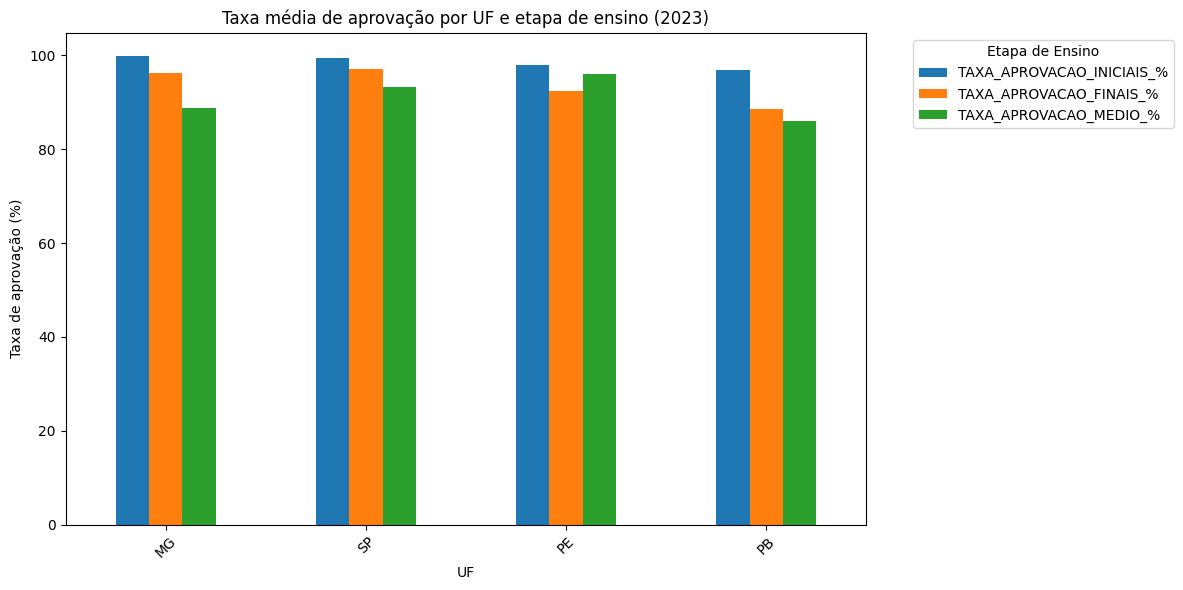

In [13]:
import matplotlib.pyplot as plt

tabela_uf.plot(kind="bar", figsize=(12,6))
plt.title("Taxa média de aprovação por UF e etapa de ensino (2023)")
plt.ylabel("Taxa de aprovação (%)")
plt.xlabel("UF")
plt.xticks(rotation=45)

# Legenda fora do gráfico, no lado direito
plt.legend(title="Etapa de Ensino", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

# Queda normal da média de aprovação ao longo dos anos escolares
# Entretanto, uma diferença perceptível dessa queda no estado da Paraíba


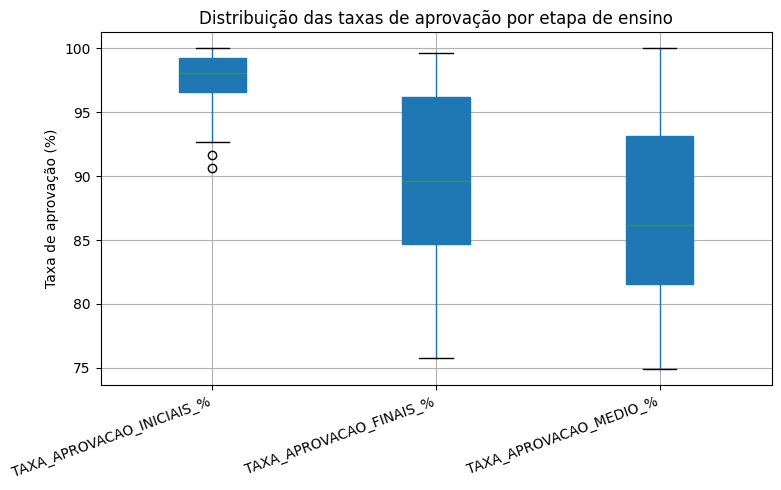

In [14]:
plt.figure(figsize=(8,5))

# Criar o boxplot e capturar o Axes
ax = res[["TAXA_APROVACAO_INICIAIS_%", "TAXA_APROVACAO_FINAIS_%", "TAXA_APROVACAO_MEDIO_%"]].boxplot(
    patch_artist=True,
    return_type='axes'
)

# Definir cores para cada caixa
cores = ["#66c2a5", "#fc8d62", "#8da0cb"]
for patch, cor in zip(ax.artists, cores):
    patch.set_facecolor(cor)

# Ajustar título e rótulos
plt.title("Distribuição das taxas de aprovação por etapa de ensino")
plt.ylabel("Taxa de aprovação (%)")
plt.xticks(rotation=20, ha="right")

plt.tight_layout()
plt.show()

# Percebemos a brusca queda das aprovações com base no nível de dificuldade do ensino
# Aprovação em massa dos anos iniciais, beirando os 100% e queda rápida ao entrar nos anos finais do fundamental e no ensino médio (Quando acontece a maiortaxa de evasão)


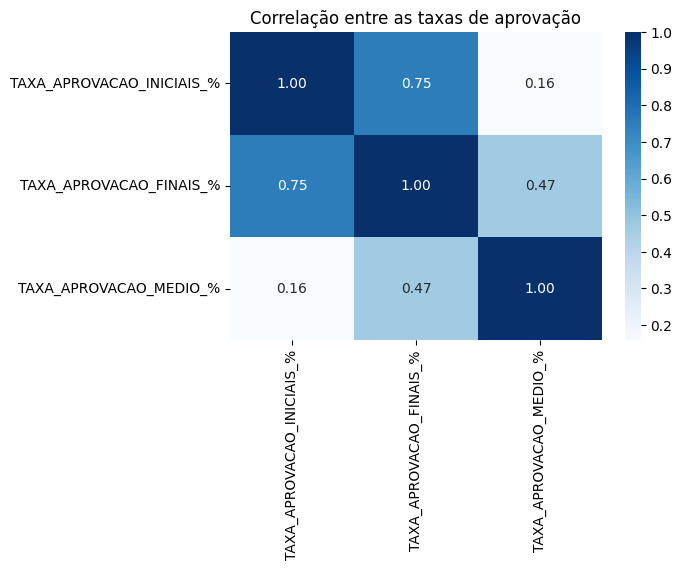

In [15]:
import seaborn as sns

plt.figure(figsize=(6,4))
corr = res[["TAXA_APROVACAO_INICIAIS_%", "TAXA_APROVACAO_FINAIS_%", "TAXA_APROVACAO_MEDIO_%"]].corr()
sns.heatmap(corr, annot=True, cmap="Blues", fmt=".2f")
plt.title("Correlação entre as taxas de aprovação")
plt.show()

# Vemos que a aprovação que mais se correlaciona com as outras é a aprovação dos anos finais
# Também percebemos a baixissima correlação da aprovação dos anos iniciais com o ensino médio, devido ao nível de ambas 